In [19]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import matplotlib.pyplot as plt
import seaborn as sns

from cloudpickle import dump

import warnings
warnings.filterwarnings('once')

from feature_engine.datetime import DatetimeFeatures

from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# skforecast

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax
from pmdarima import ARIMA

from darts import TimeSeries
from darts.models import (
    LightGBMModel,
    XGBModel,
    Prophet,
    AutoARIMA,
    LinearRegressionModel,
)
from darts.metrics import (
    smape, mape, mae, mse,
)
from darts.dataprocessing.transformers import Scaler, InvertibleMapper

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

In [20]:
def add_time_features(ride_counts, time_col):
    """add a bunch of useful time-related features"""

    season_month = {12:'Winter', 1:'Winter', 2:'Winter',
                    3:'Spring', 4:'Spring', 5:'Spring',
                    6:'Summer', 7:'Summer', 8:'Summer',
                    9:'Autumn', 10:'Autumn', 11:'Autumn'}

    ride_counts['date'] = ride_counts.loc[:, time_col].dt.date

    dtfs = DatetimeFeatures(
                variables=time_col,
                features_to_extract=["year", "quarter", "month",
                                     "hour", "day_of_week", "weekend"],
                drop_original=False,
    )
    ride_counts = dtfs.fit_transform(ride_counts)
    ride_counts.columns = ride_counts.columns.str.removeprefix('time_')
    ride_counts.loc[:, 'season'] = ride_counts['month'].map(season_month)

    holidays = calendar().holidays(start=ride_counts[time_col].min(), end=ride_counts[time_col].max())
    ride_counts['is_holiday'] = pd.to_datetime(ride_counts.loc[:, 'date']).isin(holidays)
    ride_counts['is_workday'] = ~(ride_counts['weekend'] | ride_counts['is_holiday'])

    return ride_counts

In [21]:
weather_data = pd.read_csv("data/DCweather_clean.csv",
                      parse_dates=['datetime'],
                      index_col='datetime')

In [22]:
ride_counts_all = pd.read_csv("data/ride_counts_ALL.csv", parse_dates=['time'])

In [23]:
# define training, validation (and test splits)
# dataset starts 2021-03-01, ends 2023-05-31
end_train = '2023-2-28 23:59:00'
end_val = '2023-05-31 23:59:00'

In [24]:
# rule = "2H"
# SAMPLES_PER_DAY = 12

# ride_counts_all = ride_counts_all.resample(rule, on='time').sum().reset_index()
# weather_data = weather_data.asfreq(rule)

In [25]:
# add time features, and join with weather data on time index

data = ride_counts_all.loc[:, ['time', 'rides_out', 'rides_in']]
data = add_time_features(data, 'time').set_index('time')
data = data.join(weather_data).asfreq("H").ffill()

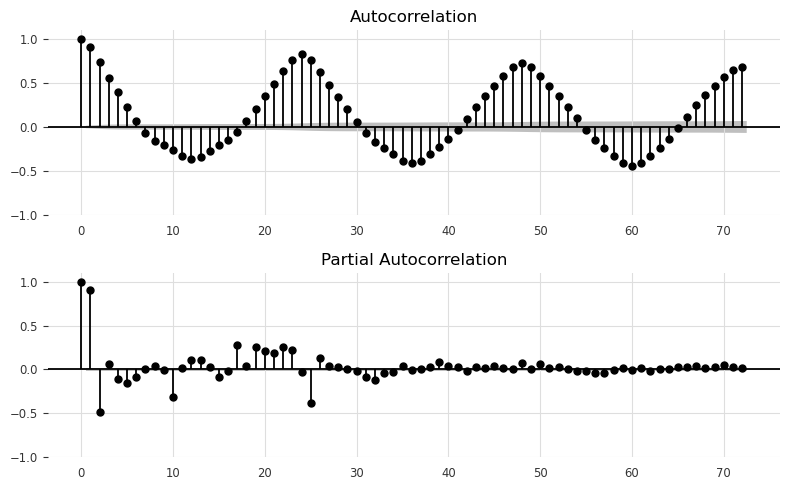

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2, 1, figsize=(8,5))
plot_acf(data['rides_out'], lags=72, ax=axs[0])
plot_pacf(data['rides_out'], lags=72, ax=axs[1])
axs[0].set_ylim([-1, 1.1])
axs[1].set_ylim([-1, 1.1])
fig.tight_layout()
plt.savefig('figs/acf_pacf.png', format='png', transparent=True)
plt.show()

In [26]:
data['net_rides'] = data['rides_in'] - data['rides_out']

In [27]:
data_col = 'rides_out'
data_train = data.loc[:end_train, data_col]
data_val = data.loc[end_train:end_val, data_col]
data_test = data.loc[end_val:, data_col]

In [28]:
# Create data transformers

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi),
                               feature_names_out='one-to-one',
                               validate=False)

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi),
                               feature_names_out='one-to-one',
                               validate=False)

# exogenous data column transformer
categorical_columns = [
    "is_workday",
    "is_holiday",
    "rush_hour",
    "condition",
    "season",
    "year",
]

categories = [
    [False, True],
    [False, True],
    [False, True],
    ["rainy", "cloudy", "clear"],
    ["Winter", "Autumn", "Spring", "Summer"],
    [2021, 2022, 2023],
]

transformer_exog = ColumnTransformer(
    transformers=[
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
        ("categories", OrdinalEncoder(categories=categories), categorical_columns)
    ],
    remainder='passthrough',
)

In [13]:
def define_exog(data, data_cols):
    exog = data.drop(data_cols, axis=1)
    exog.drop(["date", "quarter", "feelslike", "visibility"], axis=1, inplace=True)
    exog[['year', 'day_of_week', 'weekend']] = exog[['year', 'day_of_week', 'weekend']].astype("category")
    exog['rush_hour'] = ((exog['hour'] > 5) & (exog['hour'] <= 9)) | ((exog['hour'] >= 16) & (exog['hour'] < 20))
    exog['condition'].replace({'rainy':0, 'cloudy':1, 'clear':2}, inplace=True)
    exog['season'].replace({'Winter':0, 'Autumn':1, 'Spring':1, 'Summer':2}, inplace=True)
    return exog

exog_cols = ['year', 'month', 'hour', 'is_workday', 'is_holiday', 'rush_hour', 'condition']
exog = define_exog(data, ['rides_out', 'rides_in'])

Forecasting using DARTS package

In [18]:
train_ts = TimeSeries.from_series(data_train)
val_ts = TimeSeries.from_series(data_val)
exog_ts = TimeSeries.from_dataframe(exog.loc[:end_train, exog_cols])
exog_val = TimeSeries.from_dataframe(exog.loc[end_train:end_val, exog_cols])

encoders = {
    'cyclic': {'future': ['month', 'hour']},
    #'datetime_attribute': {'future': ['year']},
    #'transformer': Scaler())
}

def eval_model(model):
    model.fit(
        train_ts,
        future_covariates=exog_ts,
        max_samples_per_ts=24*100,

    )
    forecast = model.predict(
        n = len(val_ts),
        future_covariates=exog_val,
    )
    print("model {} obtains mae: {:.2f}".format(model, mae(val_ts, forecast)))
    return forecast

In [22]:
lags = [-1, -24, -168]

xgb_forecast = eval_model(
    XGBModel(
        lags=lags,
        output_chunk_length=24,
        add_encoders=encoders,
        lags_future_covariates=[0],
        **{'n_estimators':20, 'max_depth':10},
        ),
)

model MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                

229.1311497259615

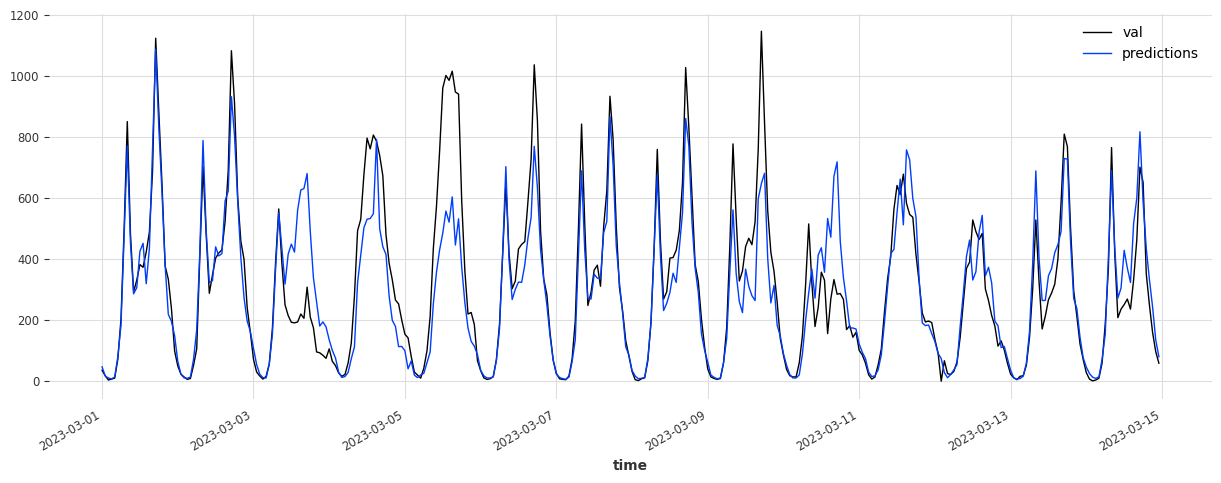

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
#train_ts[-24*7:].plot(label="train", linewidth=1)
val_ts[:24*14].plot(label="val", linewidth=1)
xgb_forecast[:24*14].plot(label="predictions", linewidth=1)
ax.set_ylabel('')

mae(val_ts, xgb_forecast)

In [ ]:
# optuna objective function for LightGBM
def objective(trial):

    # set input_chunk_length, between 5 and 14 days
    #days_in = trial.suggest_int("days_in", 5, 14)
    #in_len = days_in * 24 # 24H in a day

    # set out_len, between 1 and 14 days
    #days_out = trial.suggest_int("days_out", 1, 14)
    days_out = 7
    out_len = days_out * 24

    # Other hyperparameters

    n_estimators = trial.suggest_int("n_estimators", 5, 50)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)

    # build and fit XGB model
    model = LightGBMModel(
        lags=[-1, -12, -12*7],
        output_chunk_length=out_len,
        add_encoders=encoders,
        lags_future_covariates=[0],
        **{"n_estimators": n_estimators, "max_depth": max_depth, "learning_rate": lr},
    )

    model.fit(
        train_ts_log,
        future_covariates=exog_ts,
        max_samples_per_ts=1000,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(
        n=len(val_ts_log),
        future_covariates=exog_val,
    )
    #errors = smape(val_ts_log, preds, n_jobs=-1, verbose=True)
    errors = mae(val_ts, preds)
    error_val = np.mean(errors)

    return error_val if error_val != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")
study.optimize(objective, timeout=60, callbacks=[print_callback])

In [ ]:
def eval_model(preds, name, train_set=train_ts, val_set=val_ts):
    smapes = smape(preds, val_set)
    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))

    plt.figure(figsize=(15, 5))
    train_set[-7 * 24 :].plot()
    val_set[:7*24].plot(label="actual")
    preds[:7*24].plot(label="forecast")

best_model = XGBModel(
        lags=2,
        output_chunk_length=7*24,
        add_encoders=encoders,
        lags_future_covariates=[0],
        **{"n_estimators": 36, "max_depth": 35},
    )

best_model.fit(
        train_ts,
        future_covariates=exog_ts,
        max_samples_per_ts=1000,
    )
best_preds = best_model.predict(
    n=len(val_ts),
    future_covariates=exog_val,
)
eval_model(best_preds, "best model")

### Forecast using skforecast (with grid-search cross-validation)

In [31]:
models = [XGBRegressor(random_state=123),
          HistGradientBoostingRegressor(random_state=123),
          LGBMRegressor(random_state=123)]

# Hyperparameter to search for each model
param_grids = {'XGBRegressor': {'n_estimators': [10, 20, 50, 100], 'max_depth': [5, 10, 15, 20]},
               'HistGradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 1], 'max_depth': [5, 10, 15, 20]},
               'LGBMRegressor': {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 20, 50, 100], 'max_depth': [5, 10, 15, 20]},
               }

metrics = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error']

# Lags used as predictors
lags_grid = [1, [1, 24], [1, 24, 24*7]]

df_results = pd.DataFrame()
all_forecasters = {}

for i, model in enumerate(models):

    forecaster = ForecasterAutoreg(
            regressor = model,
            lags      = 3, # Placeholder, the value will be overwritten
            transformer_exog=transformer_exog,
            )
    param_grid = param_grids[list(param_grids)[i]]

    results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, data_col],
                   exog               = exog.loc[:end_val, exog_cols],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 24*7,
                   refit              = False,
                   metric             = metrics,
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

    # Create a column with model name
    results_grid['model'] = list(param_grids)[i]

    df_results = pd.concat([df_results, results_grid])

    # save the forecasters
    all_forecasters[list(param_grids.keys())[i]] = forecaster

df_results = df_results.sort_values(by='mean_absolute_error')

Number of models compared: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  24 168] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 25320.6523445856

Number of models compared: 36.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  24 168] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5}
  Backtesting metric: 26118.506665466233

Number of models compared: 144.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/48 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1  24 168] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 25699.058961909526



In [32]:
df_results['max_depth'] = df_results['max_depth'].astype(int)
df_results[['mean_squared_error', 'mean_absolute_error']] = np.round(df_results[
    ['mean_squared_error', 'mean_absolute_error']], 2)
df_results[['model', 'lags', 'max_depth', 'n_estimators', 'learning_rate',
            'mean_squared_error', 'mean_absolute_error']].head(10)

,model,lags,max_depth,n_estimators,learning_rate,mean_squared_error,mean_absolute_error
38,XGBRegressor,"[1, 24, 168]",10,50.0,NaN,26222.92,98.15
127,LGBMRegressor,"[1, 24, 168]",20,100.0,0.1,25699.06,99.00
123,LGBMRegressor,"[1, 24, 168]",15,100.0,0.1,25699.06,99.00
119,LGBMRegressor,"[1, 24, 168]",10,100.0,0.1,26041.72,100.11
30,HistGradientBoostingRegressor,"[1, 24, 168]",15,NaN,0.1,26293.65,100.18
31,HistGradientBoostingRegressor,"[1, 24, 168]",20,NaN,0.1,26293.65,100.18
34,XGBRegressor,"[1, 24, 168]",5,50.0,NaN,25320.65,100.29
28,HistGradientBoostingRegressor,"[1, 24, 168]",5,NaN,0.1,26118.51,100.50
29,HistGradientBoostingRegressor,"[1, 24, 168]",10,NaN,0.1,26498.97,100.75
37,XGBRegressor,"[1, 24, 168]",10,20.0,NaN,28280.25,101.88


We can check here that what our features matrix looks like (if the column transformers are applied)

In [1]:
train_X, train_y = forecaster.create_train_X_y(
    y=data.loc[:end_val, data_col],
    exog=exog.loc[:end_val, exog_cols],
)
train_X.head()

NameError: name 'forecaster' is not defined

In [34]:
# Backtesting on training data
# ==============================================================================
best_forecaster = all_forecasters['XGBRegressor']

metric, predictions_test = backtesting_forecaster(
                            forecaster         = best_forecaster,
                            y                  = data.loc[:end_val, data_col],
                            exog=exog.loc[:end_val, exog_cols],
                            initial_train_size = None,
                            fixed_train_size   = False,
                            steps              = 24*7,
                            refit              = False,
                            metric             = ['mean_squared_error', 'mean_absolute_error'],
                            n_jobs             = 'auto',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest mse: {metric[0]:.2f}, mae: {metric[1]:.2f}")

  0%|          | 0/117 [00:00<?, ?it/s]

Backtest mse: 14696.43, mae: 74.62


The good thing about a model based on decision trees is that a human-understandable feature importance can be extracted. This tells us that lag_1 is the most important feature, followed by lag_168 and hour_cos.
lag_168 is the ride count at the same time the week before (so the same hour and same day of the week).
The cosine of the hour captures the periodicity of the daily bike counts, as the cosine period of hour is 0 when hour=12, and 1 when hour is 0.

In [36]:
feature_importances = best_forecaster.regressor.feature_importances_
feature_names = best_forecaster.regressor.feature_names_in_
features_dict = {k:np.round(v,3) for k,v in zip(feature_names, feature_importances)}
features_df = pd.DataFrame.from_dict(data=features_dict, orient='index', \
                                     columns=["importance"]).sort_values(by="importance", ascending=False)
features_df

,importance
lag_1,0.635
lag_168,0.107
hour_cos__hour,0.101
hour_sin__hour,0.039
categories__is_workday,0.039
lag_24,0.026
categories__condition,0.017
categories__rush_hour,0.010
month_cos__month,0.006
categories__is_holiday,0.005


In [37]:
# Backtesting (evaluation) on test data
# ==============================================================================
best_forecaster = all_forecasters['XGBRegressor']

metric, predictions_test = backtesting_forecaster(
                            forecaster         = best_forecaster,
                            y                  = data.loc[:, data_col],
                            exog=exog.loc[:, exog_cols],
                            initial_train_size = len(data.loc[:end_val, data_col]),
                            fixed_train_size   = False,
                            steps              = 24*28,
                            refit              = False,
                            interval           = [5, 95],
                            n_boot             = 100,
                            metric             = ['mean_squared_error', 'mean_absolute_error'],
                            n_jobs             = 'auto',
                            verbose            = False # Change to True to see detailed information
                      )        

print(f"Backtest mse: {metric[0]:.2f}, mae: {metric[1]:.2f}")

  0%|          | 0/2 [00:00<?, ?it/s]

Backtest mse: 21500.60, mae: 101.15


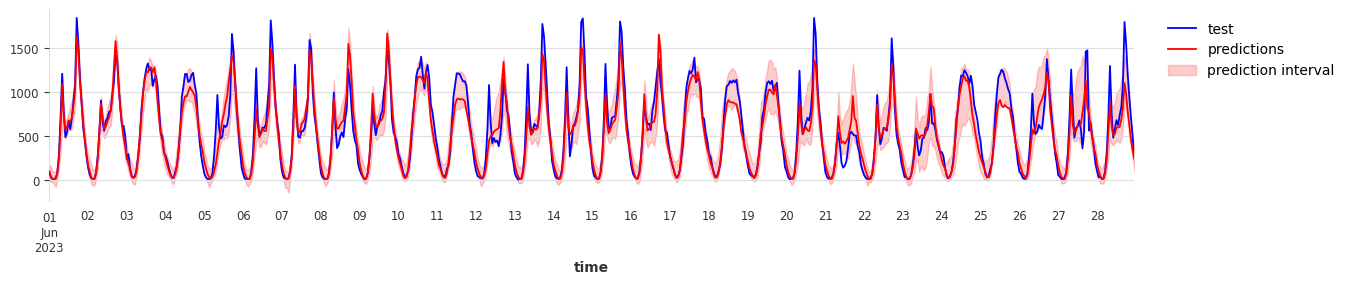

In [38]:
# Plot
fig, ax = plt.subplots(figsize=(14, 2.5))
#data_val.iloc[-24*14:].plot(ax=ax, label='val', color='k')
data_test.iloc[:24*28].plot(ax=ax, label='test', color='b')
predictions_test['pred'][:24*28].plot(ax=ax, label='predictions', color='r')
ax.fill_between(
    predictions_test.index,
    predictions_test['lower_bound'],
    predictions_test['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
_ = ax.legend(bbox_to_anchor=(1.02, 1))

plt.savefig("figs/allrides_XGBbest_testpred_wseason.png", format="png", transparent=True, bbox_inches="tight")

In [20]:
from cloudpickle import dump

with open("XGB_testmodel.pkl", "wb") as pkl_file:
        dump(best_forecaster, pkl_file)